### Install Packages


In [ ]:
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import json
import zipfile

In [ ]:
print(tf.__version__)

2.16.1


### Load Data dan Preprocessing

In [ ]:
from google.colab import drive
# Menghubungkan ke Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the dataset directory
dataset_dir = '/content/drive/MyDrive/Coconut Tree Disease Dataset'
class_folders = ["Bud Root Dropping", "Bud Rot", "Gray Leaf Spot", "Leaf Rot", "Stem Bleeding"]

In [ ]:
!pip install python_splitter

In [ ]:
import python_splitter

# Membagi dataset menjadi train, test, dan validation
python_splitter.split_from_folder(dataset_dir, train=0.8, test=0.1, val=0.1)

# Path to the new dataset directory
split_dir = 'Train_Test_Folder'

# Memeriksa folder yang dibuat
print("Directories in the split dataset:")
print(os.listdir(split_dir))

print("Train subdirectories:")
print(os.listdir(os.path.join(split_dir, 'train')))

print("Test subdirectories:")
print(os.listdir(os.path.join(split_dir, 'test')))

print("Validation subdirectories:")
print(os.listdir(os.path.join(split_dir, 'val')))

✅Checking SOURCE directory...
0.8 0.1 0.1
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 
Directories in the split dataset:
['train', 'test', 'val']
Train subdirectories:
['Bud Rot', 'Gray Leaf Spot', 'Stem Bleeding', 'Leaf Rot', 'Bud Root Dropping']
Test subdirectories:
['Bud Rot', 'Gray Leaf Spot', 'Stem Bleeding', 'Leaf Rot', 'Bud Root Dropping']
Validation subdirectories:
['Bud Rot', 'Gray Leaf Spot', 'Stem Bleeding', 'Leaf Rot', 'Bud Root Dropping']


In [ ]:
def image_transform(image):
    # Resize the image to 256x256
    resized_image = tf.image.resize(image, [256, 256])
    # Convert the image to float32 tensor
    tensor_image = tf.image.convert_image_dtype(resized_image, tf.float32)
    return tensor_image


In [ ]:
def is_valid_image(file_path):
    try:
        # Membaca file gambar menggunakan TensorFlow
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)  # Menentukan jumlah saluran (channels)
        return True
    except tf.errors.InvalidArgumentError:  # Menggunakan exception dari TensorFlow untuk gambar yang tidak valid
        return False

In [ ]:
#Preprocessing
# Membuat generator data untuk memuat dan melakukan transformasi data
# datagen = ImageDataGenerator(
#     preprocessing_function=image_transform,  # Transformasi gambar
#     #validation_split=0.2  # Split data menjadi data latih dan data validasi
# )
# Data generators
datagen = ImageDataGenerator(rescale=1./255)
# Paths to the split dataset directories
split_dir = 'Train_Test_Folder'
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')
test_dir = os.path.join(split_dir, 'test')

# Memuat dataset dari direktori
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)
# Menampilkan item-item pada atribut class_to_idx
print(train_generator.class_indices.items())

Found 3657 images belonging to 5 classes.
Found 457 images belonging to 5 classes.
Found 460 images belonging to 5 classes.
dict_items([('Bud Root Dropping', 0), ('Bud Rot', 1), ('Gray Leaf Spot', 2), ('Leaf Rot', 3), ('Stem Bleeding', 4)])


In [ ]:
# Mengambil kelas-kelas yang valid (tidak sama dengan 'drive')
valid_classes = [cls for cls in train_generator.class_indices.keys() if cls != 'drive']

# Membuat kamus yang memetakan kelas ke indeks
valid_class_to_idx = {cls: idx for idx, cls in enumerate(valid_classes)}


In [ ]:
# Membuat kamus kelas ke indeks
valid_class_to_idx = {cls: idx for idx, cls in enumerate(valid_classes)}
train_generator.class_indices = valid_class_to_idx

# Menampilkan item-item pada atribut class_to_idx
print(train_generator.class_indices.items())


dict_items([('Bud Root Dropping', 0), ('Bud Rot', 1), ('Gray Leaf Spot', 2), ('Leaf Rot', 3), ('Stem Bleeding', 4)])


### Visualisasi

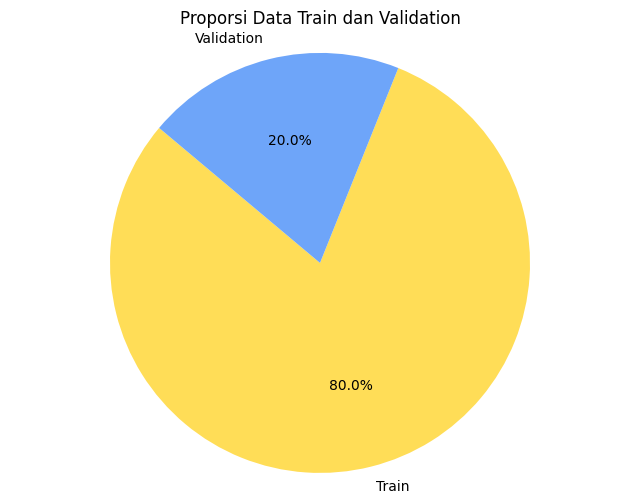

In [ ]:
train_total = train_generator.samples
val_total = val_generator.samples
# Menghitung jumlah data train dan val
total_train_samples = train_total
total_val_samples = val_total

# Membuat visualisasi
plt.figure(figsize=(8, 6))

# Visualisasi jumlah data train dan val sebagai pie chart
labels = ['Train', 'Validation']
sizes = [total_train_samples, total_val_samples]
colors = ['#ffdd57', '#6ea5f9']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proporsi Data Train dan Validation')
plt.axis('equal')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Mendefinisikan jumlah kelas
num_classes = len(class_folders)

# Menginisialisasi count untuk setiap kelas
train_class_count = {class_name: 0 for class_name in class_folders}
val_class_count = {class_name: 0 for class_name in class_folders}

# Menghitung jumlah sampel tiap kelas pada data train
for _, labels in train_generator:
    for label in labels:
        class_name = class_folders[np.argmax(label)]
        train_class_count[class_name] += 1

# Menghitung jumlah sampel tiap kelas pada data val
for _, labels in val_generator:
    for label in labels:
        class_name = class_folders[np.argmax(label)]
        val_class_count[class_name] += 1

# Membuat visualisasi
plt.figure(figsize=(12, 6))

# Visualisasi data train
plt.subplot(1, 2, 1)
plt.bar(train_class_count.keys(), train_class_count.values(), color='blue')
plt.title('Train Data')
plt.ylabel('Jumlah Sampel')
plt.xlabel('Kelas')
plt.xticks(rotation=45)

# Visualisasi data val
plt.subplot(1, 2, 2)
plt.bar(val_class_count.keys(), val_class_count.values(), color='orange')
plt.title('Validation Data')
plt.ylabel('Jumlah Sampel')
plt.xlabel('Kelas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

### Training Model

In [ ]:
batch_size = 16
lr = 1e-3
num_epochs = 5

In [ ]:
# Load MobileNetV2 model with pretrained weights
mobilenet_v2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the pretrained layers
mobilenet_v2.trainable = False

# Add custom classification head
num_classes = len(class_folders)
x = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_v2.output)
output = Dense(num_classes, activation='softmax')(x)

# Create new model
model = Model(inputs=mobilenet_v2.input, outputs=output)

# Define loss, optimizer, and metrics
criterion = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=criterion, metrics=[SparseCategoricalAccuracy()])

# Train and validation data generators
#train_generator = tf.keras.preprocessing.image.ImageDataGenerator()
#val_generator = tf.keras.preprocessing.image.ImageDataGenerator()

#train_data = train_generator.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=batch_size, class_mode='sparse', shuffle=True)
#val_data = val_generator.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=batch_size, class_mode='sparse', shuffle=False)

# Train the model
model.fit(train_generator,
          validation_data=val_generator,
          epochs=num_epochs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - loss: 0.7260 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.1445 - val_sparse_categorical_accuracy: 0.9519
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 0.0952 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.0682 - val_sparse_categorical_accuracy: 0.9869
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0463 - val_sparse_categorical_accuracy: 0.9934
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0387 - val_sparse_categorical_accuracy: 0.9891
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0295 - val_sparse_categorical_accuracy: 0.9956


### Evaluasi Model

In [ ]:
#Evaluating Model
loss, accuracy = model.evaluate(test_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0595 - sparse_categorical_accuracy: 0.9818
Validation Loss: 0.05344199016690254
Validation Accuracy: 0.9847826361656189


In [ ]:
#Classification Report
from sklearn.metrics import classification_report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes))

15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      0.98      0.99        47
           2       1.00      0.95      0.98       133
           3       0.96      1.00      0.98       168
           4       1.00      1.00      1.00        60

    accuracy                           0.98       460
   macro avg       0.99      0.99      0.99       460
weighted avg       0.99      0.98      0.98       460



In [ ]:
# Plot the metrics
def plot_metrics(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(history)


In [ ]:
# Evaluate on validation dataset
val_predictions = []
val_labels = []

for images, labels in val_dataset:
    preds = model.predict(images)
    val_predictions.extend(tf.argmax(preds, axis=1).numpy())
    val_labels.extend(labels.numpy())

val_accuracy = accuracy_score(val_labels, val_predictions)
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
val_cm = confusion_matrix(val_labels, val_predictions)
val_precision = precision_score(val_labels, val_predictions, average=None)
val_recall = recall_score(val_labels, val_predictions, average=None)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

In [ ]:
def plot_precision_recall_curve(y_true, y_pred, num_classes):
    precision = [precision_score(y_true, y_pred, average='micro')]
    recall = [recall_score(y_true, y_pred, average='micro')]

    for class_idx in range(num_classes):
        precision.append(precision_score(y_true == class_idx, y_pred == class_idx))
        recall.append(recall_score(y_true == class_idx, y_pred == class_idx))

    plt.figure(figsize=(12, 6))
    plt.bar(range(num_classes + 1), precision, color='blue', alpha=0.7, label='Precision')
    plt.bar(range(num_classes + 1), recall, color='green', alpha=0.7, label='Recall')
    plt.xticks(range(num_classes + 1), ['Overall'] + class_folders, rotation=45)

### Import Model

In [ ]:
# Simpan model ke dalam file HDF5
model.save('model.h5')

# Buat file zip
with zipfile.ZipFile('model.zip', 'w') as zipf:
    zipf.write('model.h5')


In [ ]:
  # Simpan model ke dalam format .keras
  model.save("model.keras")

  # Simpan konfigurasi model ke dalam file config.json
  config = model.get_config()
  with open("config.json", "w") as json_file:
      json.dump(config, json_file)

  # Simpan label class ke dalam file labels.txt (opsional)
  class_labels = train_generator.class_indices
  with open("labels.txt", "w") as labels_file:
      labels_file.write("\n".join(class_labels.keys()))

  # Buat file ZIP dan tambahkan model, konfigurasi, dan file lainnya
  with zipfile.ZipFile("model.zip", "w") as zipf:
      zipf.write("model.keras")
      zipf.write("config.json")
      zipf.write("labels.txt")



Saving leaf.png to leaf.png


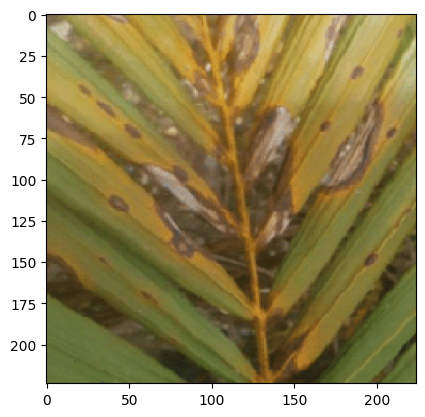

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
File: leaf.png
Predicted class: 2
Predictions: [[1.1428479e-03 4.0459173e-04 7.9705513e-01 1.6475126e-01 3.6646198e-02]]


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
# Load the trained model
model = tf.keras.models.load_model("model.keras")

# Fungsi untuk memprediksi gambar baru
def predict_new_image(image_path, model):
    # Load dan pra-pemrosesan gambar baru
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi gambar

    # Lakukan prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class, predictions

# Mengunggah dan memprediksi gambar baru
uploaded = files.upload()

for fn in uploaded.keys():
    # Menampilkan gambar
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    imgplot = plt.imshow(img)
    plt.show()

    # Prediksi gambar
    predicted_class, predictions = predict_new_image(path, model)
    print(f"File: {fn}")
    print(f"Predicted class: {predicted_class[0]}")
    print(f"Predictions: {predictions}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files

# Load the trained model
model = load_model("model.keras")

# Fungsi untuk memprediksi gambar baru
def predict_new_image(image_path, model):
    # Load dan pra-pemrosesan gambar baru
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi gambar

    # Lakukan prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class, predictions

# Mengunggah dan memprediksi gambar baru
uploaded = files.upload()

for fn in uploaded.keys():
    # Menampilkan gambar
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    # Prediksi gambar
    predicted_class, predictions = predict_new_image(path, model)
    print(f"File: {fn}")
    print(f"Predicted class: {predicted_class[0]}")
    print(f"Predictions: {predictions}")

    # Menampilkan hasil prediksi dengan label kelas
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    print(f"Predicted class label: {class_labels[predicted_class[0]]}")

Saving BudRootDropping101.jpg to BudRootDropping101.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: BudRootDropping101.jpg
Predicted class: 0
Predictions: [[9.9348128e-01 2.1659047e-05 8.7919565e-05 5.9961313e-03 4.1311758e-04]]
Predicted class label: Bud Root Dropping


Saving BudRot016.jpg to BudRot016.jpg


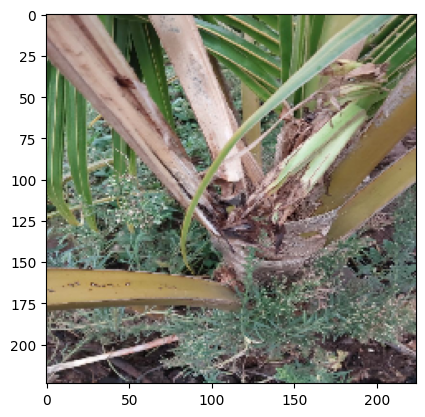

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
File: BudRot016.jpg
Predicted class: 1
Predictions: [[6.78612514e-06 9.74814236e-01 2.09671278e-02 4.10949811e-03
  1.02436126e-04]]
Predicted class label: Bud Rot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files

# Load the trained model
model = load_model("model.keras")

# Fungsi untuk memprediksi gambar baru
def predict_new_image(image_path, model):
    # Load dan pra-pemrosesan gambar baru
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi gambar

    # Lakukan prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class, predictions

# Mengunggah dan memprediksi gambar baru
uploaded = files.upload()

for fn in uploaded.keys():
    # Menampilkan gambar
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    # Prediksi gambar
    predicted_class, predictions = predict_new_image(path, model)
    print(f"File: {fn}")
    print(f"Predicted class: {predicted_class[0]}")
    print(f"Predictions: {predictions}")

    # Menampilkan hasil prediksi dengan label kelas
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    print(f"Predicted class label: {class_labels[predicted_class[0]]}")

Saving bud.png to bud (3).png


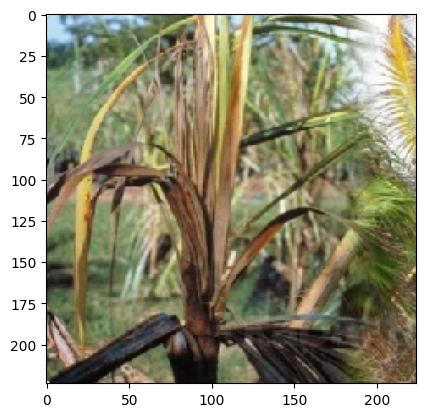

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: bud (3).png
Predicted class: 2
Predictions: [[0.19103724 0.05594186 0.62853324 0.12262581 0.00186177]]
Predicted class label: Gray Leaf Spot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files

# Load the trained model
model = load_model("model.keras")

# Fungsi untuk memprediksi gambar baru
def predict_new_image(image_path, model):
    # Load dan pra-pemrosesan gambar baru
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi gambar

    # Lakukan prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class, predictions

# Mengunggah dan memprediksi gambar baru
uploaded = files.upload()

for fn in uploaded.keys():
    # Menampilkan gambar
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    # Prediksi gambar
    predicted_class, predictions = predict_new_image(path, model)
    print(f"File: {fn}")
    print(f"Predicted class: {predicted_class[0]}")
    print(f"Predictions: {predictions}")

    # Menampilkan hasil prediksi dengan label kelas
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    print(f"Predicted class label: {class_labels[predicted_class[0]]}")